## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="k_tensor_denoiser_3", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda")


## Загрузка данных

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=16, val_batch_size=4
    ) \
    .load_feature(
        shape=(64, 80, 80), feature_name="K_abs_noised.tensor", mapper=lambda path: read_mc_tensor(path, (((0., 1.)), None)), transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="K_abs.xls", mapper=lambda path: read_matrix(path), transform=None
    ) \

print(env.train_count, env.val_count)

ValueError: object of too small depth for desired array

## Модели

### Новая локальная модель

In [8]:
env.model = models.autoencoders.ConvAutoencoderLumaRelu8(in_channels=64, out_channels=1).to(env.device)

In [11]:
env.model

ConvAutoencoderLumaRelu8(
  (encoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): AvgPool2d(kernel_size=2, stride=1, padding=1)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(1, 1))
  )
)

### Импорт претренерованной модели

In [7]:
env.load_model(model_type="pt")

TypeError: ConvAutoencoderLuma.__init__() missing 2 required positional arguments: 'in_channels' and 'out_channels'

## Визуализация батча валидационного датасета

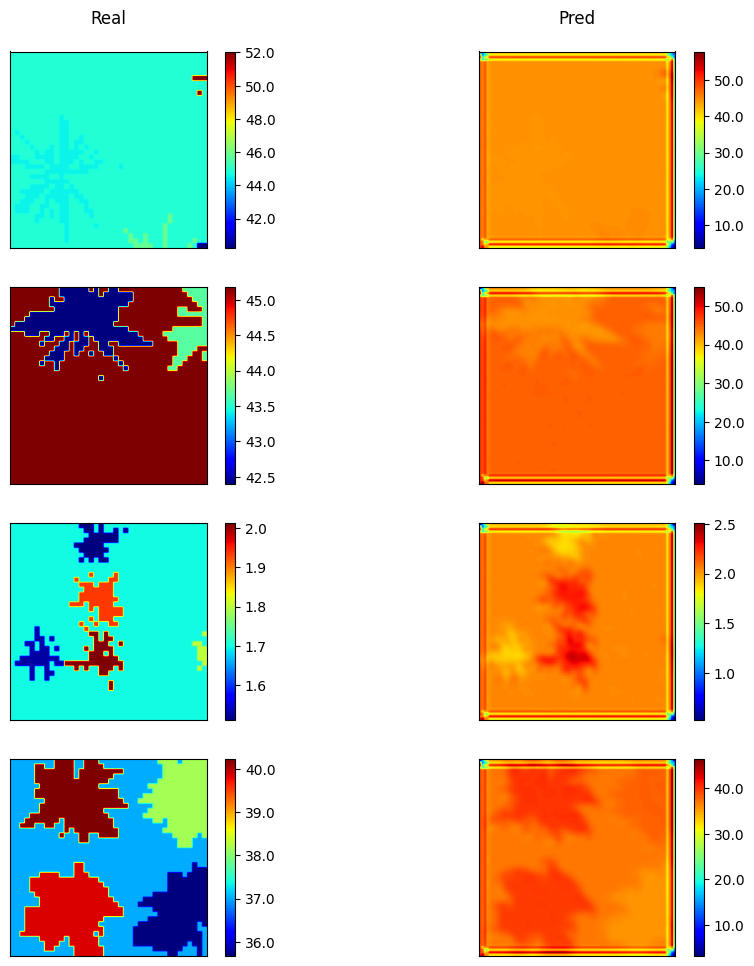

In [33]:
env.plot_batch(concrete=5, figsize=(10, 10), format="%.1f", wspace=0.0, hspace=0.2)


## Численные значения отклонений

In [30]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            for ex_id in range(env.val_batch_size):
                
                for j in range(64):
                    losses_dataset_step = torch.mean(torch.abs(data_features[0][ex_id][j] - data_target[ex_id])).detach().tolist()
                    losses_dataset.append(losses_dataset_step)
                    
                    init_error = torch.mean(torch.abs(data_features[0][ex_id][j] - data_target[ex_id]) / data_target[ex_id])
                    init_errors.append(init_error.detach().tolist())
                
                loss = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / data_target[ex_id])
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.6074315004598247
Текущее среднее отклонение по значениям: 0.29994630126748234

Начальное максимальное отклонение по значениям: 1.2703033685684204
Текущее максимальное отклонение по значениям в векторе: 1.5500177145004272

Начальная средняя относительная ошибка: 0.024994828536364366
Текущая средняя относительная ошибка: 0.01677366027433891

Начальная максимальная относительная ошибка: 0.02572666108608246
Текущая максимальная относительная ошибка: 0.08197460323572159


## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [13]:
env.train(10, step_saving=False, step_plotting=False,
          optimizer=torch.optim.Adam(env.model.parameters(), lr=0.01), scheduler=None, 
          criterion=torch.nn.BCELoss(reduction="none", reduce="none"))

/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 3.032132 	Validating Loss: 0.695596 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.691567 	Validating Loss: 0.697662 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.691231 	Validating Loss: 0.697039 	Time: 0.42 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.6

In [10]:
env.set_name_model("k_tensor_denoiser_1")

In [31]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, verbose=True)


In [36]:
env.train(30 , step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.MSELoss(reduce="none", reduction="none"), callbacks=[lambda: scheduler.step(env.test_losses[-1])])


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 1.781186 	Validating Loss: 1.422220 	Time: 0.60 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 1.788211 	Validating Loss: 2.131769 	Time: 0.56 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 2.341177 	Validating Loss: 1.300081 	Time: 0.52 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 1.5

KeyboardInterrupt: 

## Сохранение модели

In [27]:
env.save(onnx=False, pth=False)

## Loss visualisation

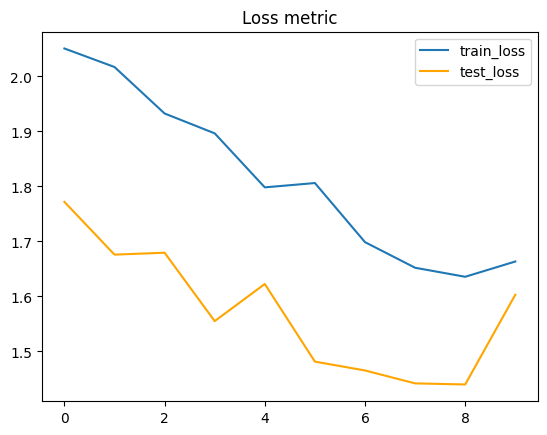

In [35]:
env.show_metrics(n_last=10, train=True, val=True)

## Clear memory

In [12]:
import gc
gc.collect()


42128

In [3]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

AttributeError: 'NoneType' object has no attribute 'cpu'